In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy import stats
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    VotingClassifier, RandomForestRegressor, ExtraTreesClassifier,
    StackingClassifier
)
from sklearn.linear_model import (
    LogisticRegression, SGDClassifier
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score,
    log_loss
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, StandardScaler
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, linear_model, neighbors, ensemble, tree
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.pipeline import make_pipeline

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

import pickle

os.environ['LOKY_MAX_CPU_COUNT'] = '4'

import xgboost as xgb
from xgboost import XGBClassifier



In [40]:
# Read the CSV file with specified data types
df = pd.read_csv('final_dataset.csv', low_memory=False)

In [42]:
print(df['loan_term'].value_counts())

loan_term
0.833333    38578
0.333333     7074
0.500000     2943
0.166667      848
0.666667      173
0.000000       70
1.000000        2
Name: count, dtype: int64


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   census_tract                              49688 non-null  float64
 1   action_taken                              49688 non-null  float64
 2   loan_type                                 49688 non-null  float64
 3   lien_status                               49688 non-null  float64
 4   reverse_mortgage                          49688 non-null  float64
 5   open_end_line_of_credit                   49688 non-null  float64
 6   loan_amount                               49688 non-null  float64
 7   combined_loan_to_value_ratio              49688 non-null  float64
 8   interest_rate                             49688 non-null  float64
 9   total_loan_costs                          49688 non-null  float64
 10  origination_charges               

In [5]:
random_state=42

In [6]:
df['interest_rate'].value_counts()

interest_rate
0.333333    31919
0.444444     6928
0.222222     5076
0.555556     2800
0.111111     1489
0.666667     1307
0.777778      142
1.000000       11
0.888889        8
0.000000        7
0.353567        1
Name: count, dtype: int64

In [7]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Define the minority classes for each column
minority_classes = {
    'applicant_sex': [0.2, 1.0, 0.4],
    'co_applicant_sex': [0.0, 1.0],
    'applicant_race_1': [0.0],
    'co_applicant_race_1': [0.0],
    'applicant_ethnicity_1': [0.0],
    'co_applicant_ethnicity_1': [0.0],
}

# Create a dictionary to store resampled datasets for each column
resampled_datasets = {}

# Create a new DataFrame to store the resampled data
resampled_df = df.copy()

# Iterate through the columns and apply SMOTE to each
for column in df.columns:
    if column in minority_classes:
        # Select the specific column
        selected_column = df[column].values.reshape(-1, 1)

        # Define y_min based on the minority class for this column
        y_min = [1 if value in minority_classes[column] else 0 for value in df[column]]

        # Apply SMOTE to the selected column with a reduced sampling strategy
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(selected_column, y_min)

        # Ensure that the resampled data has the same number of rows as the original DataFrame
        if len(X_resampled) > len(df):
            X_resampled = X_resampled[:len(df)]
            y_resampled = y_resampled[:len(df)]

        # Update the resampled data in the new DataFrame
        resampled_df[column] = X_resampled.flatten()

# Now, 'resampled_df' contains all 35 columns with the necessary resampling applied to specific columns


In [8]:
resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   census_tract                              49688 non-null  float64
 1   action_taken                              49688 non-null  float64
 2   loan_type                                 49688 non-null  float64
 3   lien_status                               49688 non-null  float64
 4   reverse_mortgage                          49688 non-null  float64
 5   open_end_line_of_credit                   49688 non-null  float64
 6   loan_amount                               49688 non-null  float64
 7   combined_loan_to_value_ratio              49688 non-null  float64
 8   interest_rate                             49688 non-null  float64
 9   total_loan_costs                          49688 non-null  float64
 10  origination_charges               

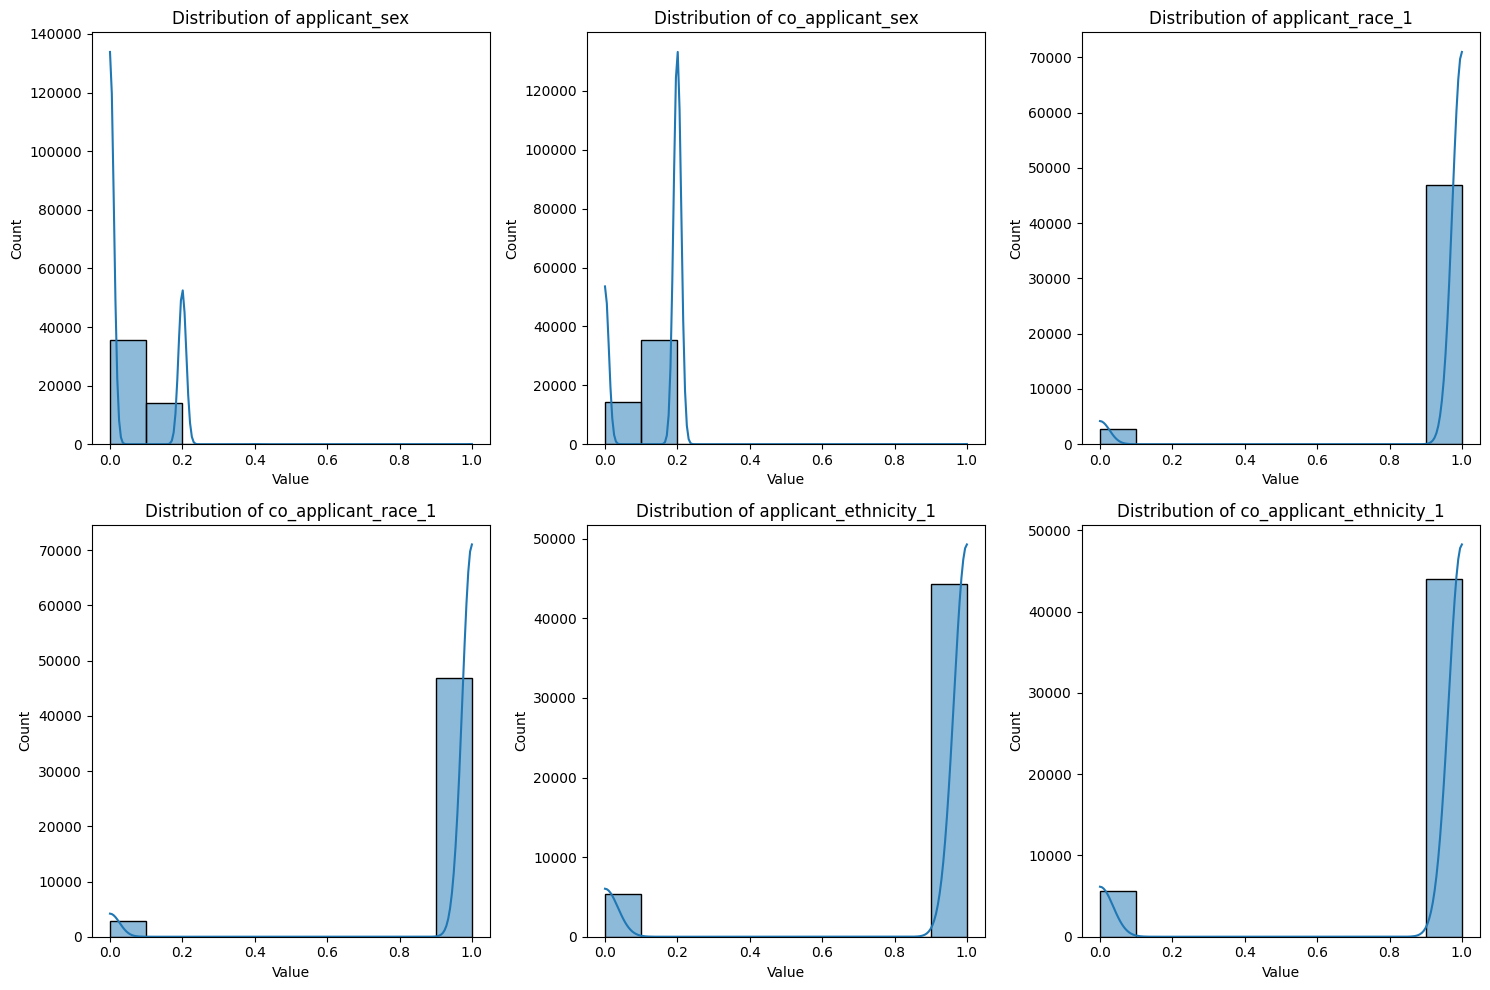

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a list of columns for which you want to plot the distribution
columns_to_plot = list(minority_classes.keys())

# Calculate the number of plots and rows
num_plots = len(columns_to_plot)
num_rows = (num_plots // 3) + (num_plots % 3)

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.ravel()

for i, column in enumerate(columns_to_plot):
    # Extract the resampled values for the current column from the resampled_df
    values = resampled_df[column]

    # Create a histogram plot
    g = sns.histplot(values, ax=axes[i], bins=10, kde=True)
    g.set_title(f'Distribution of {column}')
    g.set_xlabel("Value")
    g.set_ylabel("Count")

# Hide any empty subplots
for i in range(num_plots, num_rows * 3):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


# Logistic Regression

In [10]:
X = resampled_df.drop('action_taken', axis=1)
y = resampled_df['action_taken']

In [11]:
# Split your data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, split the training data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
LR = LogisticRegression(penalty='l2', max_iter=1000, C=1.0) 
LR.fit(X_train, y_train)

y_predict = LR.predict(X_train) 
print(f"The accuracy for training: {LR.score(X_train, y_train)}") 
print(f"The accuracy for validation: {LR.score(X_val, y_val)}") 
print(f"F1 score for validation: {f1_score(LR.predict(X_val), y_val)}")

The accuracy for training: 0.6987106918238993
The accuracy for validation: 0.6930817610062893
F1 score for validation: 0.6291793313069909


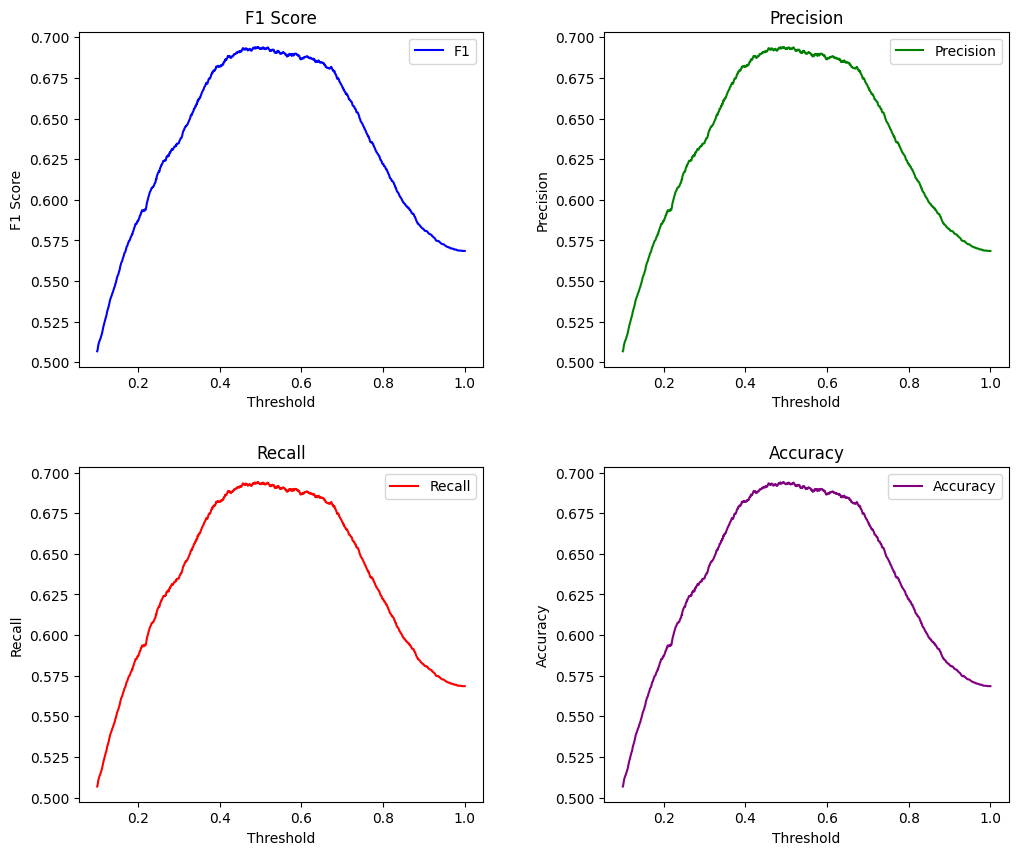

Logistic Regression Model best F1 score 0.694 at prob decision threshold >= 0.493


In [13]:
thresh_ps = np.linspace(.10, 1, 1000)
model_val_probs = LR.predict_proba(X_val)[:, 1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
best_f1_score, best_thresh_p = 0, 0  # Initialize best F1 score and threshold

for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    prec_scores.append(precision_score(y_val, model_val_labels, average='micro'))
    rec_scores.append(recall_score(y_val, model_val_labels, average='micro'))
    f1 = f1_score(y_val, model_val_labels, average='micro')
    f1_scores.append(f1)
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_thresh_p = p

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Plot F1 score
axes[0, 0].plot(thresh_ps, f1_scores, label='F1', color='blue')
axes[0, 0].set_title('F1 Score')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('F1 Score')

# Plot Precision
axes[0, 1].plot(thresh_ps, prec_scores, label='Precision', color='green')
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Precision')

# Plot Recall
axes[1, 0].plot(thresh_ps, rec_scores, label='Recall', color='red')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Recall')

# Plot Accuracy
axes[1, 1].plot(thresh_ps, acc_scores, label='Accuracy', color='purple')
axes[1, 1].set_title('Accuracy')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Accuracy')

# Add legends to each subplot
for ax in axes.flatten():
    ax.legend()

# Display the plots
plt.show()


print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))


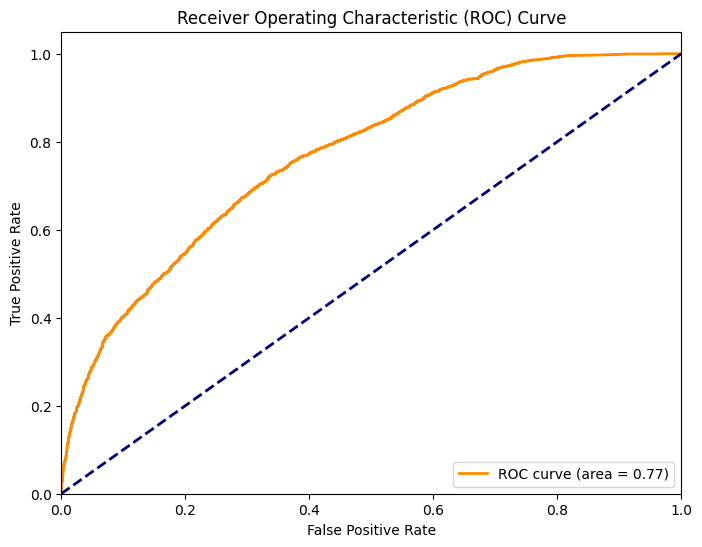

In [14]:
# Get the predicted probabilities for the positive class
model_val_probs = LR.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [15]:
y_predict = (LR.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 0.7708,   Recall: 0.3900


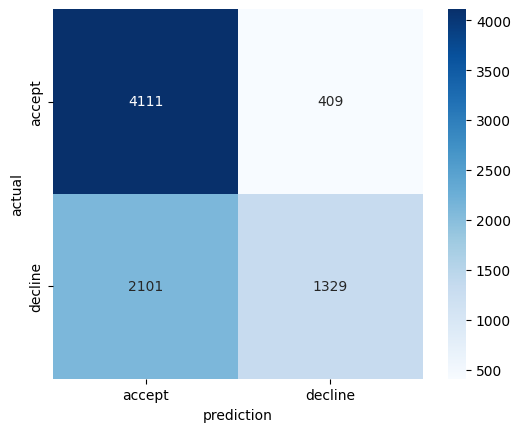

In [16]:
y_predict = (LR.predict_proba(X_val)[:, 1] >= 0.65)

confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

Conclusion: clearly overfitting. 

# KNeighborsClassifier

In [17]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Now, you can calculate the accuracy and F1 score
print('The accuracy for training : ', knn.score(X_train, y_train))
print('The accuracy for validation: ', knn.score(X_val, y_val))
print('F1_score for train: ', f1_score(knn.predict(X_train), y_train))
print('F1_score for validation: ', f1_score(knn.predict(X_val), y_val))

The accuracy for training :  0.9232389937106918
The accuracy for validation:  0.8494339622641509
F1_score for train:  0.9176534088992342
F1_score for validation:  0.8430987023200943


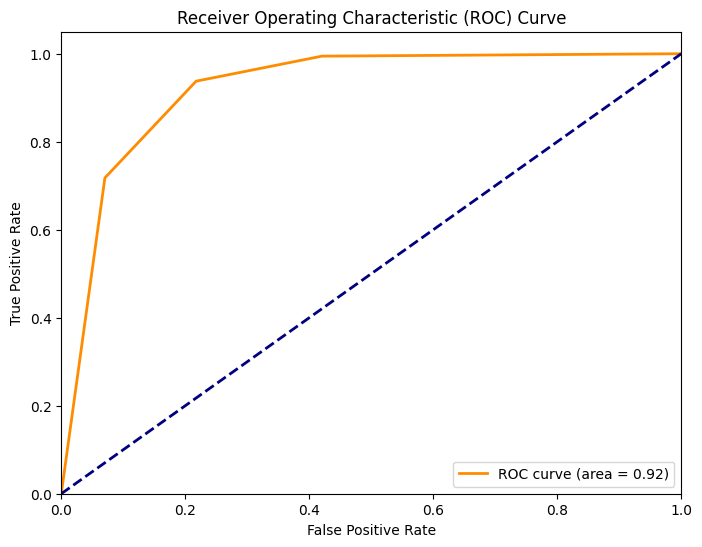

In [18]:
# Get the predicted probabilities for the positive class
model_val_probs = knn.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [19]:
y_predict = (knn.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 0.8677,   Recall: 0.9737


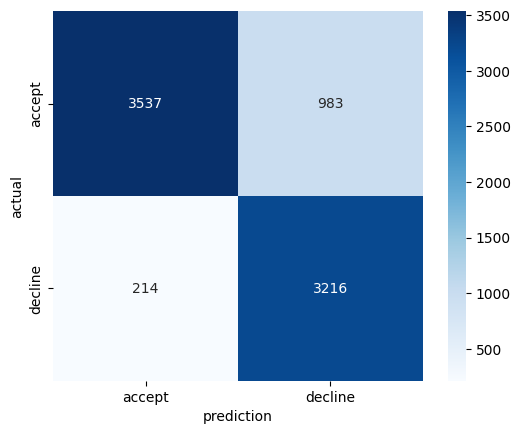

In [20]:
y_predict = (knn.predict_proba(X_val)[:, 1] >= 0.65)

confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

Conclusion: clearly overfitting. 

# Naive Bayes

In [21]:
Gaussian = GaussianNB()
Gaussian.fit(X_train, y_train)
print('The accuracy for training : ',Gaussian.score(X_train,y_train))
print('The accuracy for validation: ',Gaussian.score(X_val,y_val))
print('f1_score for train: ',f1_score(Gaussian.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(Gaussian.predict(X_val), y_val))

The accuracy for training :  0.7884276729559748
The accuracy for validation:  0.789308176100629
f1_score for train:  0.683715682587439
f1_score for validation:  0.6775745909528392


# Ada Boost Classifier

In [22]:
AB_CLF = AdaBoostClassifier(n_estimators=50, random_state=random_state)
AB_CLF.fit(X_train , y_train)
print('The accuracy for training : ',AB_CLF.score(X_train,y_train))
print('The accuracy for validation: ',AB_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(AB_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(AB_CLF.predict(X_val), y_val))

The accuracy for training :  0.9941509433962264
The accuracy for validation:  0.9953459119496856
f1_score for train:  0.9933859611691914
f1_score for validation:  0.9946353487023343


# Stochastic Gradient Descent Algorithm

In [23]:
SG_PIP_CLF = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))
SG_PIP_CLF.fit(X_train , y_train)
print('The accuracy for training : ',SG_PIP_CLF.score(X_train,y_train))
print('The accuracy for validation: ',SG_PIP_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(SG_PIP_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(SG_PIP_CLF.predict(X_val), y_val))

The accuracy for training :  0.7063522012578617
The accuracy for validation:  0.7012578616352201
f1_score for train:  0.6194163677861101
f1_score for validation:  0.6054161820900481


# XGBoost (eXtreme Gradient Boosting) - this takes a very long time!

In [24]:
# Add early stopping
early_stopping_rounds = 3

xgb_model = xgb.XGBClassifier(early_stopping_rounds=early_stopping_rounds)

parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.7],
    'n_estimators': [8000, 9000, 10000],
    'missing': [-999],
    'seed': [1337],
    'eval_metric': ['logloss'],
}

# Use 3-fold cross-validation
clf = GridSearchCV(xgb_model, parameters, n_jobs=3,
                   cv=KFold(n_splits=3, shuffle=True, random_state=random_state),
                   scoring='neg_log_loss',  
                   verbose=4, refit=True)


# Implement early stopping
eval_set = [(X_val, y_val)]
clf.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-logloss:0.53926
[1]	validation_0-logloss:0.46805
[2]	validation_0-logloss:0.36735
[3]	validation_0-logloss:0.29086
[4]	validation_0-logloss:0.26244
[5]	validation_0-logloss:0.23752
[6]	validation_0-logloss:0.19310
[7]	validation_0-logloss:0.17946
[8]	validation_0-logloss:0.15926
[9]	validation_0-logloss:0.13124
[10]	validation_0-logloss:0.11881
[11]	validation_0-logloss:0.09943
[12]	validation_0-logloss:0.08422
[13]	validation_0-logloss:0.07963
[14]	validation_0-logloss:0.06903
[15]	validation_0-logloss:0.06015
[16]	validation_0-logloss:0.05766
[17]	validation_0-logloss:0.05466
[18]	validation_0-logloss:0.04929
[19]	validation_0-logloss:0.04470
[20]	validation_0-logloss:0.04287
[21]	validation_0-logloss:0.04167
[22]	validation_0-logloss:0.03819
[23]	validation_0-logloss:0.03554
[24]	validation_0-logloss:0.03347
[25]	validation_0-logloss:0.03268
[26]	validation_0-logloss:0.03097
[27]	validation_0-logloss:0.0

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=3,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     intera...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=3,
             param_grid={'colsample_bytree': [0.7], 'eval_metric': ['logloss'],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 5, 10],
                         'missing': [-999], 'n_estimators': [8000, 9000, 10000],
                         'nthread': [4], 'objective': ['binary:logistic'],
                         'seed': [1337], 'subsample': [0.5, 0.7, 0.9]},
             scoring='neg_log_loss', verbose=4)

In [25]:
import pickle

with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [26]:
clf.best_params_

{'colsample_bytree': 0.7,
 'eval_metric': 'logloss',
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': -999,
 'n_estimators': 8000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'subsample': 0.9}

In [27]:
# Define your hyperparameters
params = {'colsample_bytree': 0.7,
 'eval_metric': 'logloss',
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': -999,
 'n_estimators': 8000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'subsample': 0.9}

In [28]:
# Train the model and monitor early stopping
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Make predictions on the test set
y_predict = (xgb_model.predict_proba(X_test)[:, 1] >= 0.59)

# Calculate precision and recall on the test set
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)

# Print test set results
print("Test set results:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

from sklearn.metrics import accuracy_score, f1_score

# Calculate other evaluation metrics
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Print other evaluation metrics
print("Test set results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

[0]	validation_0-logloss:0.43487
[1]	validation_0-logloss:0.29914
[2]	validation_0-logloss:0.21410
[3]	validation_0-logloss:0.15758
[4]	validation_0-logloss:0.11882
[5]	validation_0-logloss:0.09176
[6]	validation_0-logloss:0.07267
[7]	validation_0-logloss:0.05913
[8]	validation_0-logloss:0.04958
[9]	validation_0-logloss:0.04261
[10]	validation_0-logloss:0.03766
[11]	validation_0-logloss:0.03398
[12]	validation_0-logloss:0.03136
[13]	validation_0-logloss:0.02907
[14]	validation_0-logloss:0.02765
[15]	validation_0-logloss:0.02660
[16]	validation_0-logloss:0.02566
[17]	validation_0-logloss:0.02491
[18]	validation_0-logloss:0.02446
[19]	validation_0-logloss:0.02397
[20]	validation_0-logloss:0.02342
[21]	validation_0-logloss:0.02311
[22]	validation_0-logloss:0.02219
[23]	validation_0-logloss:0.02191
[24]	validation_0-logloss:0.02180
[25]	validation_0-logloss:0.02158
[26]	validation_0-logloss:0.02135
[27]	validation_0-logloss:0.02135
[28]	validation_0-logloss:0.02149
Test set results:
Precis

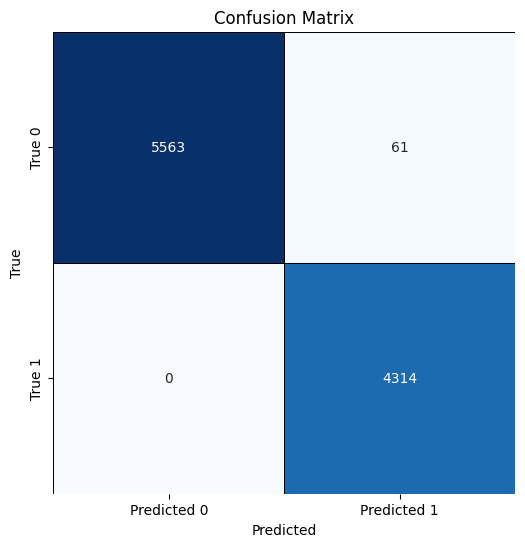

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you already have y_test and y_predict from your code

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black", square=True, cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Pickle models

In [30]:
lr_model = linear_model.LogisticRegression(solver="lbfgs", random_state=random_state)
dt_model = tree.DecisionTreeClassifier(max_depth=8)
ADA_model = AdaBoostClassifier(n_estimators=50, random_state=random_state)
SGD_model = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))

models = ["lr_model","dt_model","ADA_model","SGD_model"]

In [31]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train, y_train)
    
    with open(f"{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

C:\Users\asche\anaconda3\envs\Test\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
model_names = ["lr_model","dt_model","ADA_model","SGD_model"]

for model_name in model_names:
    with open(f"{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [33]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_train, y_train)}')
    print(f'{model_name} score: {curr_model.score(X_val, y_val)}')

lr_model score: 0.6988050314465408
lr_model score: 0.6937106918238993
dt_model score: 0.9941509433962264
dt_model score: 0.9953459119496856
ADA_model score: 0.9941509433962264
ADA_model score: 0.9953459119496856
SGD_model score: 0.6894654088050315
SGD_model score: 0.6918238993710691


# voting classifer (HARD)

In [34]:
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=42)),
                             ('dt_model', DecisionTreeClassifier(max_depth=8)),
                             ('ADA_model', AdaBoostClassifier(random_state=42)),
                             ('SGD_model',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('sgdclassifier',
                                               SGDClassifier(max_iter=100))]))],
                 n_jobs=-1)

In [35]:
y_pred = voting_classifer.predict(X_train)
accuracy_score(y_train, y_pred)

0.845691823899371

In [36]:
y_pred = voting_classifer.predict(X_val)
accuracy_score(y_val, y_pred)

0.8413836477987421

# Compare all the models.

In [37]:
# Example model and prediction data
models = ['LR', 'knn', 'Ada Boost', 'Gaussian', 'Stochastic Gradient Descent', 'xgb_model', 'Decision Tree', 'SGD_model', 'voting_classifier']
y_pred1 = LR.predict(X_val)
y_pred2 = knn.predict(X_val)
y_pred3 = AB_CLF.predict(X_val)
y_pred4 = Gaussian.predict(X_val)
y_pred5 = SG_PIP_CLF.predict(X_val)
y_pred6 = xgb_model.predict(X_val)
y_pred7 = dt_model.predict(X_val)
y_pred8 = SGD_model.predict(X_val)
y_pred9 = voting_classifer.predict(X_val)  # Fixed variable name

y_true = y_val  # True labels

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    'Accuracy': [accuracy_score(y_true, y_pred1), accuracy_score(y_true, y_pred2), accuracy_score(y_true, y_pred3),
                 accuracy_score(y_true, y_pred4), accuracy_score(y_true, y_pred5), accuracy_score(y_true, y_pred6),
                 accuracy_score(y_true, y_pred7), accuracy_score(y_true, y_pred8), accuracy_score(y_true, y_pred9)],
    
    'Precision': [precision_score(y_true, y_pred1), precision_score(y_true, y_pred2), precision_score(y_true, y_pred3),
                  precision_score(y_true, y_pred4), precision_score(y_true, y_pred5), precision_score(y_true, y_pred6),
                  precision_score(y_true, y_pred7), precision_score(y_true, y_pred8), precision_score(y_true, y_pred9)],
    
    'Recall': [recall_score(y_true, y_pred1), recall_score(y_true, y_pred2), recall_score(y_true, y_pred3),
               recall_score(y_true, y_pred4), recall_score(y_true, y_pred5), recall_score(y_true, y_pred6),
               recall_score(y_true, y_pred7), recall_score(y_true, y_pred8), recall_score(y_true, y_pred9)],
    
    'F1 Score': [f1_score(y_true, y_pred1), f1_score(y_true, y_pred2), f1_score(y_true, y_pred3),
                 f1_score(y_true, y_pred4), f1_score(y_true, y_pred5), f1_score(y_true, y_pred6),
                 f1_score(y_true, y_pred7), f1_score(y_true, y_pred8), f1_score(y_true, y_pred9)]
}

# Create a DataFrame
import pandas as pd
df = pd.DataFrame(metrics, index=models)

# Display the DataFrame
print(df)


                             Accuracy  Precision    Recall  F1 Score
LR                           0.693082   0.657143  0.603499  0.629179
knn                          0.849434   0.765897  0.937609  0.843099
Ada Boost                    0.995346   0.989328  1.000000  0.994635
Gaussian                     0.789308   0.997167  0.513120  0.677575
Stochastic Gradient Descent  0.701258   0.703747  0.531195  0.605416
xgb_model                    0.995346   0.989328  1.000000  0.994635
Decision Tree                0.995346   0.989328  1.000000  0.994635
SGD_model                    0.691824   0.650307  0.618076  0.633782
voting_classifier            0.841384   0.996793  0.634402  0.775343
